# FashionMNIST VAE

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints
#from sklearn.manifold import TSNE
from helper_functions import *



### Define the simulation parameters

In [2]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_HIDDEN_1':400,
    'DIM_HIDDEN_2':200,
    'DIM_Z':50,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'DIM_HIDDEN_1': 400, 'DIM_HIDDEN_2': 200, 'DIM_Z': 50, 'use_cuda': False}


### Get the data

torch.Size([1024, 1, 28, 28])


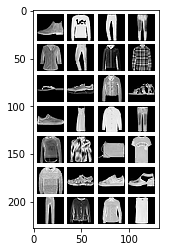

In [3]:
BATCH_SIZE = 1024
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:28],npadding=4)

### Instantiate VAE class 
This is the case without latent structure

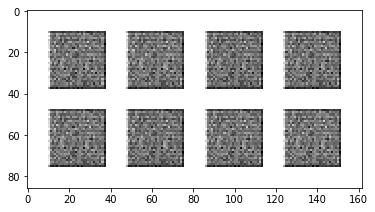

In [4]:
from encoder_decoder import *
from vae import *

#encoder = Encoder_MLP(params)
#decoder = Decoder_MLP(params)
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

vae.guide()
vae.model()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [5]:
### test_model(vae.model,vae.guide,Trace_ELBO())
### 
### #load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")
### 
### import pyro.poutine as poutine
### #
### print("----MODEL---------")
### trace = poutine.trace(vae.model).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())
### #
### print("----GUIDE ---------")
### trace = poutine.trace(vae.guide).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())

In [6]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adamax(adam_args)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
train_loss, test_loss = [], []
min_loss = 999999

In [8]:
write_dir  = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

descriptor      = "MNIST_v3"
name_vae        = "vae_"+descriptor+"_"
name_train_loss = "train_loss_"+descriptor+"_"
name_test_loss  = "test_loss_"+descriptor+"_"
name_params     = "params_"+descriptor


save_obj(params,write_dir,name_params)

In [ ]:
# training loop
for epoch in range(0,10*NUM_EPOCHS):
    vae.train()            
    
    loss = train(svi,trainloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
    train_loss.append(loss)   
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate(svi,testloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
        test_loss.append(loss)
    
        if(test_loss[-1] < min_loss):
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
            min_loss = test_loss[-1]
            #### Save if you got a record 
            ###save_model(vae,write_dir,name_vae+str(epoch))       
            ###save_obj(test_loss,write_dir,name_test_loss+str(epoch))
            ###save_obj(train_loss,write_dir,name_train_loss+str(epoch))
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
            
    if(epoch % WRITE_FREQUENCY == 0):
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(test_loss,write_dir,name_test_loss+str(epoch))
        save_obj(train_loss,write_dir,name_train_loss+str(epoch))

loss=860998.42969
loss=837667.98438
loss=814366.36719
loss=796092.43750
loss=796551.50781
loss=792168.16406
loss=784401.38281
loss=782062.28125
loss=781725.19531
loss=781979.42188
loss=780923.16016
loss=781956.69531
loss=780719.38672
loss=780336.30469
loss=780768.89453
loss=780050.57031
loss=779388.93750
loss=779023.28125
loss=777925.83594
loss=778005.74609
loss=777300.48047
loss=776568.90234
loss=775559.79688
loss=775446.62109
loss=774473.43750
loss=774157.32031
loss=773592.63281
loss=773087.92188
loss=773097.84375
loss=772298.40625
loss=772211.63281
loss=771568.83594
loss=772405.14844
loss=771502.06250
loss=771229.50000
loss=771343.14062
loss=770213.28125
loss=770484.11719
loss=770204.03125
loss=770093.60156
loss=769921.82031
loss=769043.38281
loss=769543.51562
loss=768366.86719
loss=769039.90625
loss=768190.49219
loss=768712.77344
loss=767941.57812
loss=768833.39844
loss=767575.50000
loss=768034.83594
loss=767814.89062
loss=767483.50781
loss=767208.42188
loss=767560.97656
loss=76732

# Check the results

In [ ]:
#write_dir = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

#descriptor      = "MNIST_v1"

#load_model(vae,write_dir,"vae_"+descriptor+"_400")
#test_loss = load_obj(write_dir,"test_loss_"+descriptor+"_400")
#train_loss = load_obj(write_dir,"train_loss_"+descriptor+"_400")
#name_vae = "vae_"+descriptor

In [ ]:
#plt.yscale('log')
y_shift=0
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax = 1.0)
#plt.xlim(xmin = 0, xmax=700)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
#from matplotlib import pyplot as plt
#plt.savefig(write_dir+name_vae+'train.png')

In [ ]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:12],imgs_rec[:12],npadding=4,nrow=6)